In [1]:
import json
from itertools import combinations

import numpy as np
from scipy.stats import linregress

from neuromaps import datasets
from neuromaps.transforms import mni152_to_fsaverage

from nilearn.plotting import view_surf, plot_surf
import nibabel as nib

import matplotlib.pyplot as plt

### Neuromaps Serotonin Example

This notebook compares the serontonin receptor densities of a few datasets.

In [2]:
def load_array(img_path, norm=True, density='3k'):
    """Load array from path."""
    
    gifti_lh, gifti_rh  = mni152_to_fsaverage(img_path, fsavg_density=density)

    arr_lh = gifti_lh.agg_data()
    arr_rh = gifti_rh.agg_data()
    
    if norm:
        arr_lh, arr_rh = normalize(arr_lh), normalize(arr_rh)
    
    return arr_lh, arr_rh

def normalize(arr):
    """Normalize array between 0-1."""
    
    arr -= arr.min()
    arr /= arr.max()-arr.min()
    
    return arr

In [3]:
# Get serotonin map labels
with open('data_desc.json', 'r') as f:
    data_desc = json.load(f)
    
data_desc['serotonin']

{'gallezot2010': 'serotonin 5-HT(1B) receptor',
 'fazio2016': 'serotonin transporter',
 'beliveau2017': 'seratonin agonist',
 'radnakrishnan2018': '5-HT6 receptor availability'}

In [4]:
# All volumes in MNI space
for annot in datasets.available_annotations():
    if annot[0] in data_desc['serotonin'].keys():
        print(annot)

('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('radnakrishnan2018', 'gsk215083', 'MNI152', '1mm')


In [5]:
# Fetch data
sero_gallezot = datasets.fetch_annotation(source='gallezot2010')

sero_fazio = datasets.fetch_annotation(source='fazio2016')

sero_beliveau = datasets.fetch_annotation(source='beliveau2017')
sero_beliveau = list(sero_beliveau.values())[0]

sero_radnakrishnan = datasets.fetch_annotation(source='radnakrishnan2018')

# Template
density = '3k'
fsaverage = datasets.fetch_fsaverage(density=density)

In [6]:
# Load arrays
sero_gallezot_lh, sero_gallezot_rh = load_array(sero_gallezot)
sero_fazio_lh, sero_fazio_rh = load_array(sero_fazio)
sero_beliveau_lh, sero_beliveau_rh = load_array(sero_beliveau)
sero_radnakrishnan_lh, sero_radnakrishnan_rh = load_array(sero_radnakrishnan)

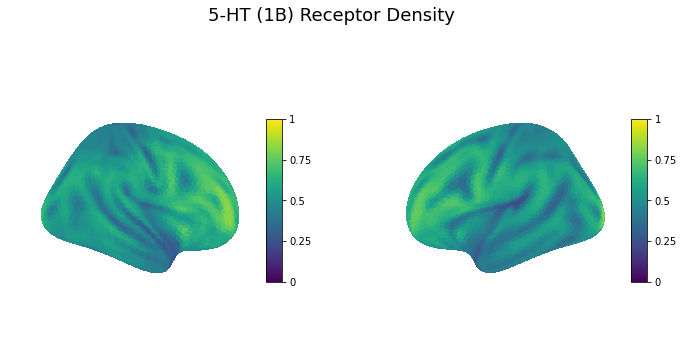

In [7]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), subplot_kw={'projection': '3d'})

plot_surf(str(fsaverage['inflated'].R), sero_gallezot_rh, symmetric_cmap=False,
          title='5-HT (1B) Receptor Density', vmin=0, vmax=1, colorbar=True, hemi='right',
          axes=axes[0])

plot_surf(str(fsaverage['inflated'].L), sero_gallezot_lh, symmetric_cmap=False,
          colorbar=True, hemi='left', vmin=0, vmax=1, axes=axes[1]);

In [8]:
# Largest correlation between Gallezot and Radnakrishnan maps
corrs_mat_rh = np.corrcoef(
    np.array([sero_gallezot_rh, sero_fazio_rh, 
              sero_beliveau_rh, sero_radnakrishnan_rh])
)

corrs_mat_lh = np.corrcoef(
    np.array([sero_gallezot_lh, sero_fazio_lh, 
              sero_beliveau_lh, sero_radnakrishnan_lh])
)

print(corrs_mat_rh)
print()
print(corrs_mat_lh)

[[1.         0.26595542 0.21928126 0.61899099]
 [0.26595542 1.         0.09883351 0.24372248]
 [0.21928126 0.09883351 1.         0.30474321]
 [0.61899099 0.24372248 0.30474321 1.        ]]

[[1.         0.2651606  0.19325907 0.61113257]
 [0.2651606  1.         0.1316569  0.30212944]
 [0.19325907 0.1316569  1.         0.29130447]
 [0.61113257 0.30212944 0.29130447 1.        ]]


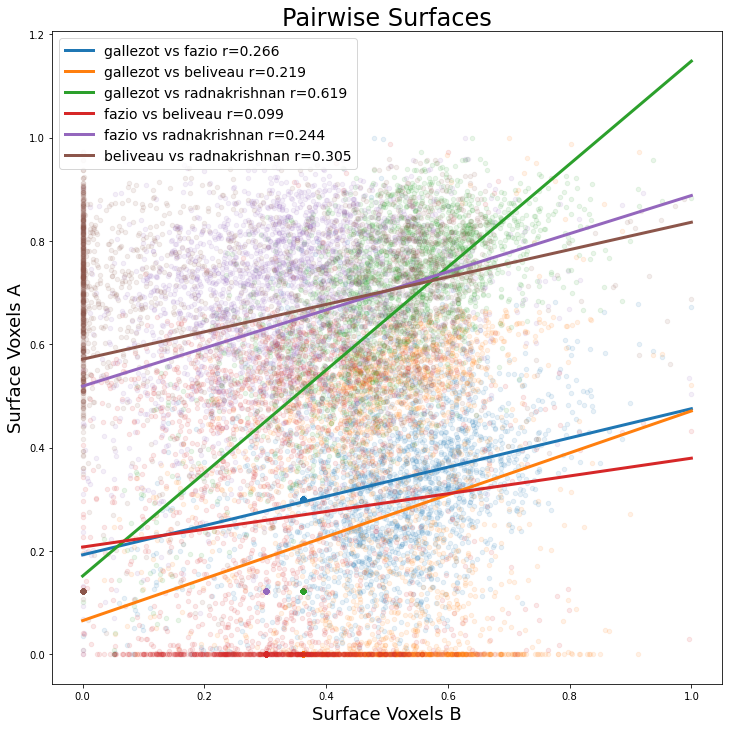

In [10]:
plt.figure(figsize=(12, 12))



labels = ['gallezot', 'fazio', 'beliveau', 'radnakrishnan']  

arrs = [sero_gallezot_rh, sero_fazio_rh, 
        sero_beliveau_rh, sero_radnakrishnan_rh]
    

for ind0, ind1 in combinations(range(len(arrs)), 2):
    
    # Plot scatter
    plt.scatter(arrs[ind0], arrs[ind1],
                alpha=.1, s=20)
    
    # Plot regression
    res = linregress(arrs[ind0], arrs[ind1])
    x = np.linspace(0, 1, len(arrs[0]))
    y = res.intercept + res.slope*x
    
    label = labels[ind0] + ' vs ' + \
        labels[ind1] + f' r={res.rvalue.round(3)}'
    
    plt.plot(x, y, label=label, lw=3)
    
plt.title('Pairwise Surfaces', size=24)

plt.ylabel('Surface Voxels A', size=18)
plt.xlabel('Surface Voxels B', size=18)
            
plt.legend(fontsize=14);